# Multi-session analysis
This notebook demonstrate how to combine different xarray dataset together and perform group-level analysis

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions
from trialexp.process.group_analysis.plot_utils import plot_group_average, plot_subject_average, plot_subject_comparison
import itertools

## Build dataframe containing the metadata of all sessions

`build_session_info` will extract information from the by_sessions folder and build a dataframe for further filtering


In [2]:
#specify the location of the by_sessions folder here
root_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'

df_session_info = build_session_info(root_path, load_pycontrol=True, pycontrol_parameters=['hold_time_required_ms', 'US_delay_ms'], param_extract_method='tail')
df_session_info['hold_time_required_ms']=df_session_info['hold_time_required_ms'].astype(float)
df_session_info['US_delay_ms'] = df_session_info['US_delay_ms'].astype(float)

## Filter data based on a pre-definied list

In [3]:
good_session_list = pd.read_csv('good_session_DA.txt')
df_sel = df_session_info[df_session_info.session_id.isin(good_session_list.session_id)]
df_sel.sort_values(['animal_id','expt_datetime']).head()

,animal_id,expt_datetime,session_id,task_name,path,session_no,US_delay_ms,hold_time_required_ms
270,JC317L,2022-12-05 17:23:59,JC317L-2022-12-05-172359,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,13.0,500.0,1000.0
347,JC318L,2022-12-05 17:17:08,JC318L-2022-12-05-171708,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,12.0,500.0,1000.0
334,JC318L,2022-12-06 17:11:08,JC318L-2022-12-06-171108,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,13.0,500.0,1000.0
172,kms058,2023-03-07 10:43:32,kms058-2023-03-07-104332,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,15.0,500.0,1000.0
400,kms058,2023-03-09 10:47:59,kms058-2023-03-09-104759,reaching_go_spout_bar_nov22,/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/...,16.0,500.0,1000.0


In [4]:
paths = df_sel.path
ds_combined = load_and_concat_dataset(paths)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms063-2023-04-01-180930/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/JC318L-2022-12-06-171108/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/JC318L-2022-12-05-171708/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms064-2023-02-14-115018/processed/xr_session.nc not found! skipping
Concating datasets...


In [5]:
ds_combined

<xarray.Dataset>
Dimensions:                           (trial_nb: 324, event_time: 500,
                                       session_id: 26)
Coordinates:
  * trial_nb                          (trial_nb) int64 1 2 3 4 ... 322 323 324
  * event_time                        (event_time) int64 -1995 -1985 ... 2995
  * session_id                        (session_id) object 'kms058-2023-03-24-...
Data variables: (12/20)
    uid                               (session_id, trial_nb) object 'kms058_2...
    trigger                           (session_id, trial_nb) object 'hold_for...
    valid                             (session_id, trial_nb) float64 1.0 ... nan
    break_after_abort                 (session_id, trial_nb) float64 0.0 ... nan
    US_end_timer                      (session_id, trial_nb) float64 1.0 ... nan
    water_on                          (session_id, trial_nb) float64 1.0 ... nan
    ...                                ...
    success                           (session_id, trial_nb) float64 1.0 ... nan
    trial_outcome                     (session_id, trial_nb) object 'success'...
    hold_for_water_zscored_df_over_f  (session_id, trial_nb, event_time) float64 ...
    first_bar_off_zscored_df_over_f   (session_id, trial_nb, event_time) float64 ...
    first_spout_zscored_df_over_f     (session_id, trial_nb, event_time) float64 ...
    last_bar_off_zscored_df_over_f    (session_id, trial_nb, event_time) float64 ...

## Plot figures

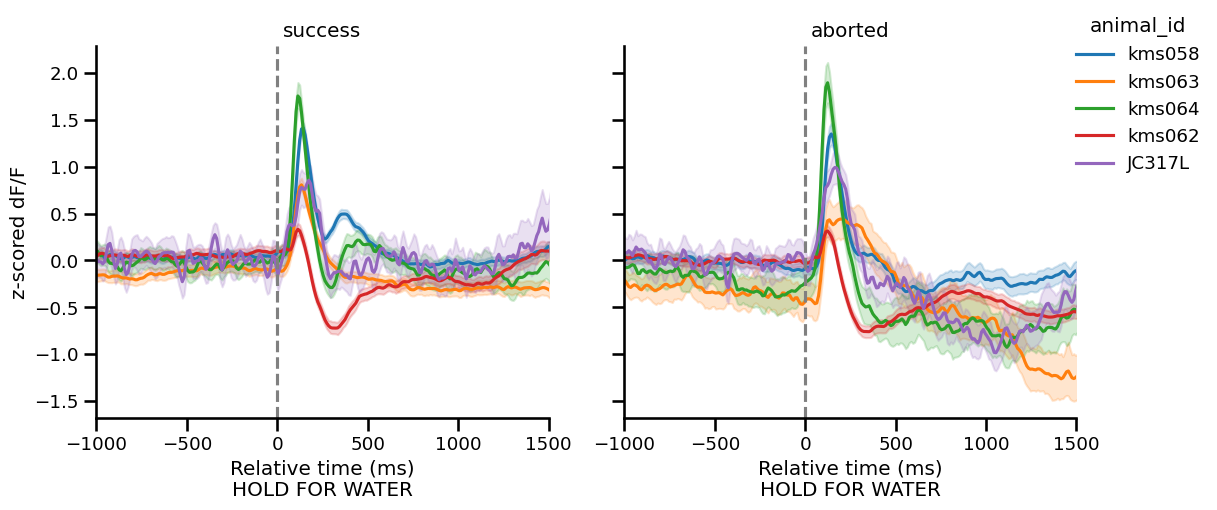

In [6]:
sns.set_context('talk',font_scale=0.8)

animal_id = df_sel[['animal_id','session_id','expt_datetime']]

plot_subject_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f');

/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


(<Figure size 540x540 with 1 Axes>,
 <Axes: xlabel='Relative time (ms)\nHOLD FOR WATER', ylabel='z-scored dF/F'>)

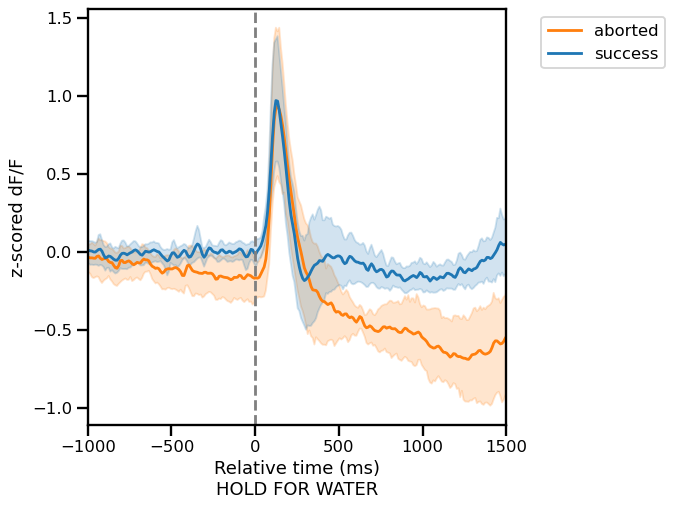

In [7]:
plot_group_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f', 
                   average_method='mean_of_mean')

Using 188 trials for each subjects


(<Figure size 540x540 with 1 Axes>,
 <Axes: xlabel='Relative time (ms)\nHOLD FOR WATER', ylabel='z-scored dF/F'>)

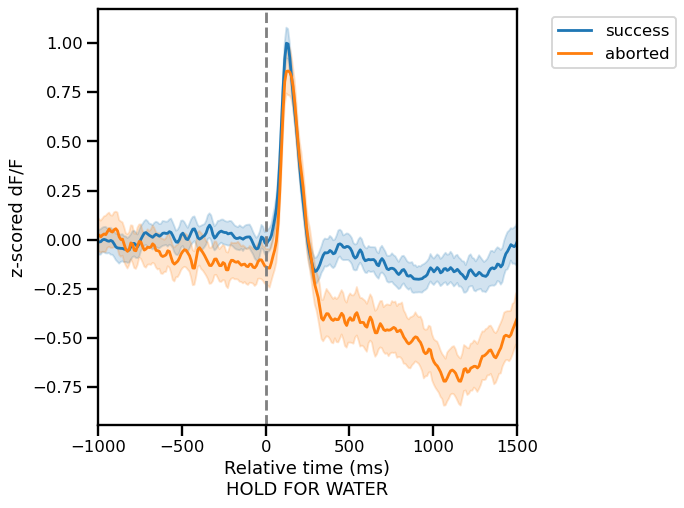

In [8]:
plot_group_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f',
                   average_method='equal_subsample')

(<Figure size 540x540 with 1 Axes>,
 <Axes: xlabel='Relative time (ms)\nHOLD FOR WATER', ylabel='z-scored dF/F'>)

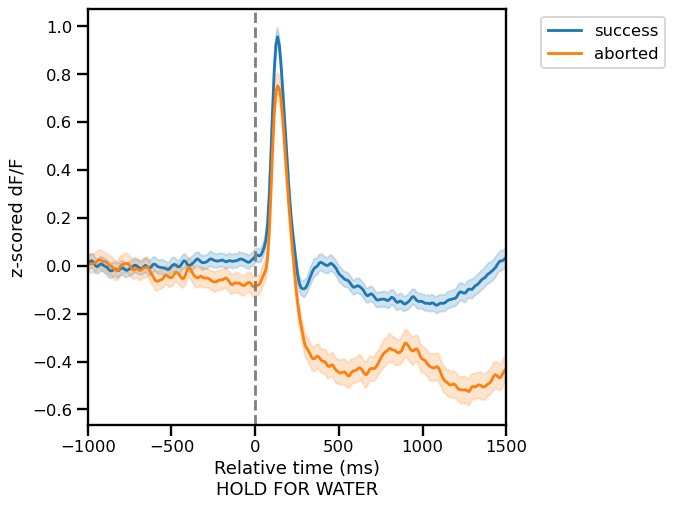

In [9]:
plot_group_average(ds_combined, animal_id, 'hold_for_water_zscored_df_over_f')

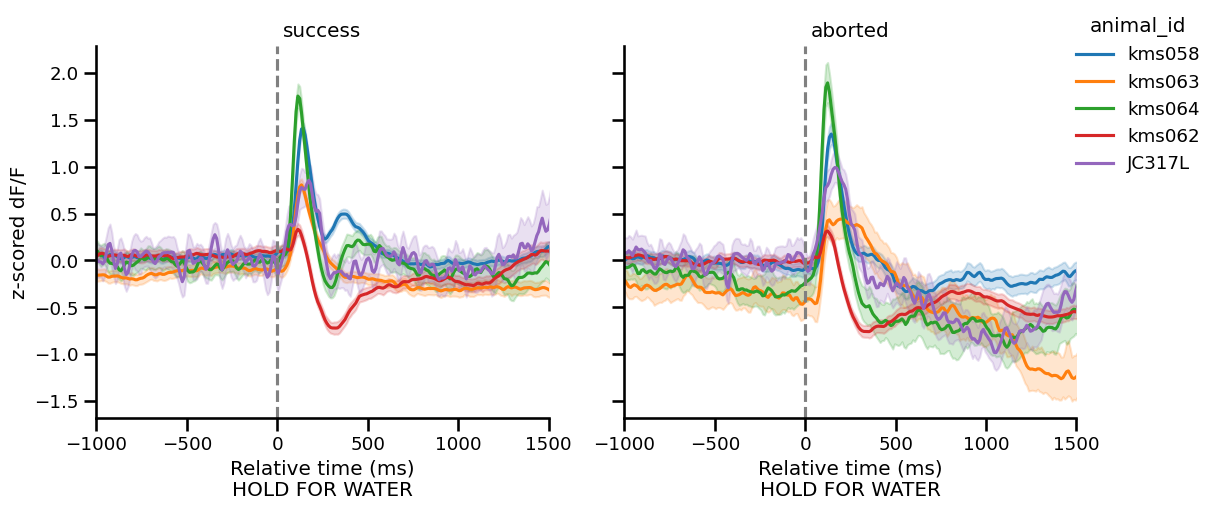

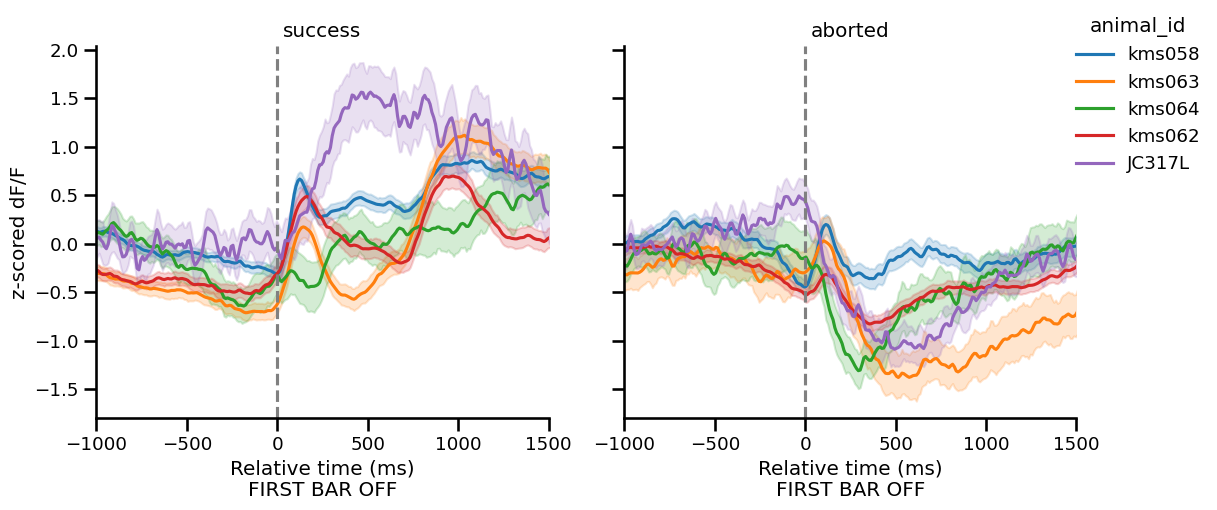

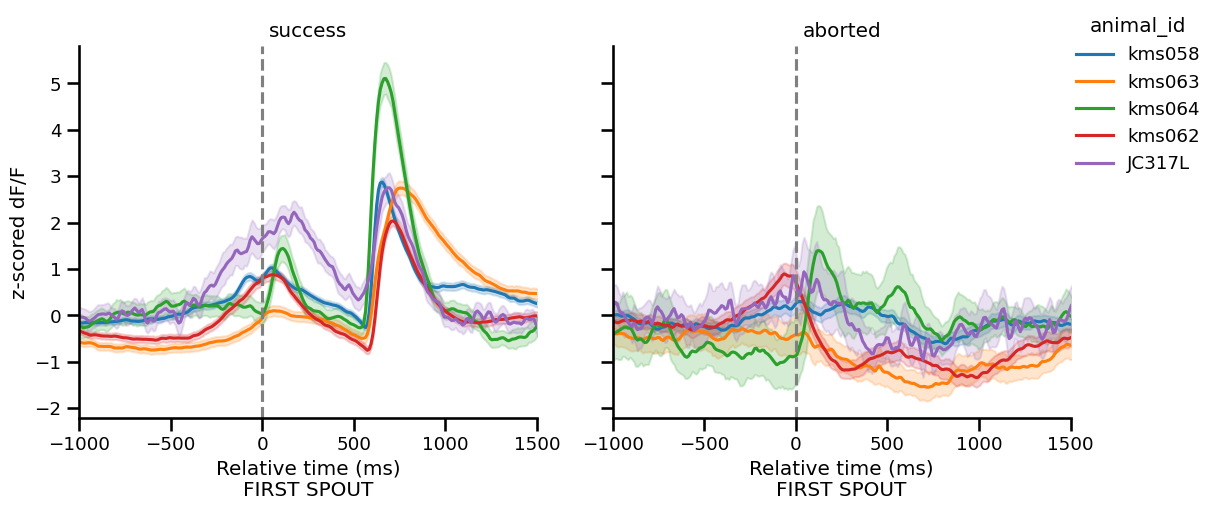

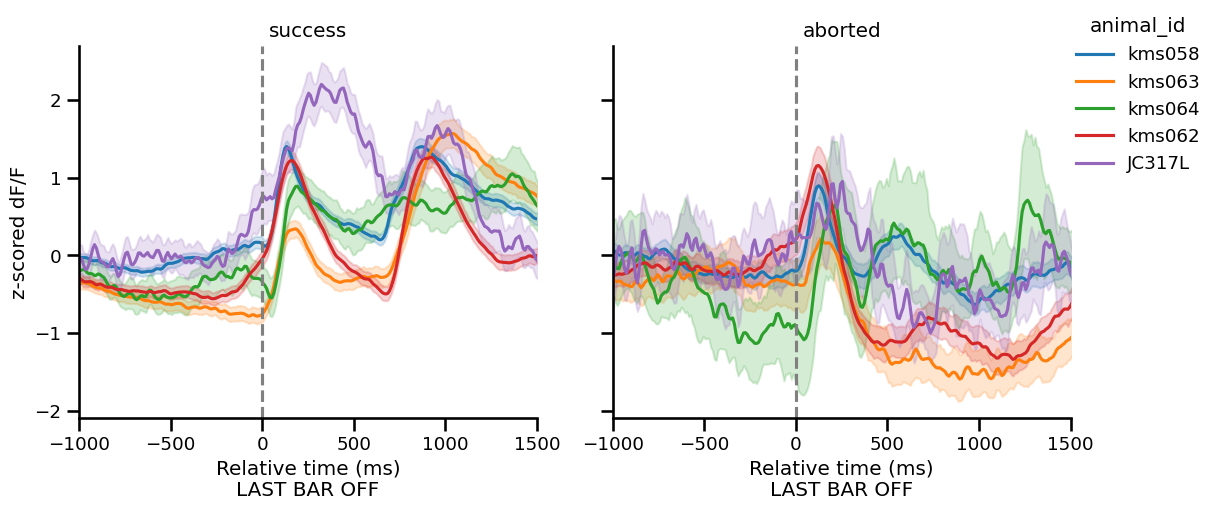

In [10]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

for v in vars_to_plot:
    fig= plot_subject_average(ds_combined, animal_id, v)
    fig.savefig(f'figures/DA_subject_average_{v}.png', bbox_inches='tight')

In [ ]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

average_mode = ['equal_subsample', 'mean_of_mean']

for v, mode in itertools.product(vars_to_plot, average_mode):
    fig, ax = plot_group_average(ds_combined, animal_id, v, average_method=mode)
    fig.savefig(f'figures/DA_group_average_{v}_{mode}.png', bbox_inches='tight')

Using 188 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 188 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 108 trials for each subjects


/home/MRC.OX.AC.UK/ndcn1330/code/trialexp/trialexp/process/group_analysis/plot_utils.py:104: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2plot = df2plot.groupby(['animal_id','event_time','trial_outcome']).mean().reset_index()


Using 107 trials for each subjects
